# Example 4 - Ferry Service with Random Demand



Let's make life easy for this one and assume the following set up:


- A ferry (or whatever) has remaining capacity S (not C, because remaining capacity is our state variable).
- Each period, the operator can set a price to sell space at.
- The ferry faces a fixed deterministic demand given by

$$q = A e^{-kp} + \varepsilon$$

$$\varepsilon \sim N(0, \sigma^{2})$$

- In a given period, the operator sets price and realizes demand. The remaining capacity they take into next period is

$$ s^{\prime} = \max\{ s - q, 0\} $$

That is, if they can't satisfy demand with the remaining space they sell nothing.

- The period payoff is 

$$ p (s - s^{\prime}) $$

## Libraries

In [1]:
import numpy as np
import pandas as pd

from markov_decision_process import TimeAugmentedMDP
from markov_decision_process.utilities import discretize_normal

from rich import print

from catboost import CatBoostClassifier

# Import isotonic regression


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

from sklearn.model_selection import train_test_split
import os

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Parameters

Same parameters as example 3, except now we add a shock to demand.

In [2]:
# Same parameters as before

max_capacity: float = 100
states: list[float] = np.linspace(0, max_capacity, 101).tolist()
actions: list[float] = np.linspace(1, 100, 31).tolist()
times: list[int] = np.arange(-30, 1).tolist()

In [3]:
# Changing the contstant A to C here because we use A for the action space
C = 10
K = 0.05
sigma = 0.001


def demand(price):
    # Let demand be linear in price
    # It can't be less than 0
    # q = 10 - .15*price
    q = C * np.exp(-K * price) + np.random.normal(0, sigma)

    return np.clip(q, 0, max_capacity)


def expected_demand(price):
    # Let demand be linear in price
    # It can't be less than 0
    # q = 10 - .15*price
    q = C * np.exp(-K * price)

    return np.clip(q, 0, max_capacity)

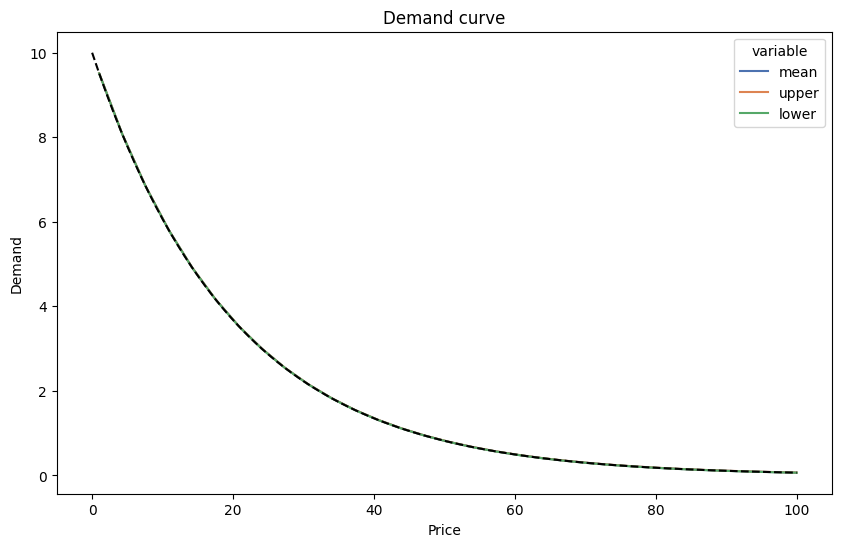

In [4]:
# Plot the demand curve

# Generate a data frame 20000 rows with random prices
prices = np.random.choice(actions, 100000)
df = pd.DataFrame({"price": prices})

# Apply to each row
df["demand"] = df["price"].apply(demand)

# Group by price, find mean and standard deviation
df = (
    df.groupby("price")
    .agg(mean=("demand", "mean"), std=("demand", "std"))
    .reset_index()
)

## Make lines for 2std above and below the mean
df["upper"] = df["mean"] + 2 * df["std"]
df["lower"] = np.clip(df["mean"] - 2 * df["std"], 0, None)

# Melt the data frame
df = df.melt(
    id_vars="price", value_vars=["mean", "upper", "lower"], value_name="demand"
)

# Expected demand
x = np.linspace(0, 100, 100)
y = expected_demand(x)

# Plot the demand curve
plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x="price", y="demand", hue="variable")
plt.plot(x, y, label="Expected demand", color="black", linestyle="--")

plt.title("Demand curve")
plt.xlabel("Price")
plt.ylabel("Demand")

plt.show()

### ML Model for Demand

First we create a bunch of training data from the demand process. 

Next we make the target variable which state would be transitioned to for a given choice of price, as a categorical variable.

Train a multiclass classification model to predict the probability that a service will move to state $s^{\prime}$ given they're in state $s$ and choose price $p$.

In [5]:
# Make a data frame where we have 100,000 rows where we have columns
# s, t, a, each a random choice from the lists S, T, A.

n = 100_000
df = pd.DataFrame(
    {
        "s": np.random.choice(states, n),
        "a": np.random.choice(actions, n),
        "t": np.random.choice(times, n),
    }
)

# Now compute demand
df["q"] = df["a"].apply(demand)

# Now compute s_prime
df["s_prime"] = np.clip(df["s"] - df["q"], 0, max_capacity)

# Round to nearest half
# df["s_prime"] = df["s_prime"].apply(lambda x: round(x * 2) / 2)
df["s_prime"] = df["s_prime"].apply(lambda x: round(x))

df["s_prime"] = pd.Categorical(df["s_prime"], categories=states)

In [6]:
# Does every category appear in s_prime?

assert set(df["s_prime"].unique()) == set(states)

In [7]:
if not os.path.exists("../../models"):
    os.makedirs("../../models")

# Assuming `self.data` is your DataFrame
train_data, test_data = train_test_split(df, test_size=0.2, random_state=2718)

TARGET = "s_prime"
FEATURES = ["s", "t", "a"]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


params = {
    "iterations": 1000,
    "loss_function": "MultiClass",
    "verbose": 50,
    "early_stopping_rounds": 20,
    "use_best_model": True,
    "task_type": "GPU",
    "train_dir": "../../models/catboost_info_sigma_{sigma}",
}


# Now you can use `train_data` for training and `test_data` for testing
model = CatBoostClassifier(**params)

# Fit the model
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Save the model
fname = f"../../models/model_{params['iterations']}_sigma_{sigma}.cbm"
model.save_model(fname)

Learning rate set to 0.163698
0:	learn: 3.9419984	test: 3.9477898	best: 3.9477898 (0)	total: 101ms	remaining: 1m 41s
50:	learn: 1.4749013	test: 1.4920885	best: 1.4920885 (50)	total: 4.09s	remaining: 1m 16s
100:	learn: 1.0320168	test: 1.0485053	best: 1.0485053 (100)	total: 8.16s	remaining: 1m 12s
150:	learn: 0.8125744	test: 0.8286285	best: 0.8286285 (150)	total: 12.2s	remaining: 1m 8s
200:	learn: 0.6660110	test: 0.6818273	best: 0.6818273 (200)	total: 16.2s	remaining: 1m 4s
250:	learn: 0.5521788	test: 0.5676897	best: 0.5676897 (250)	total: 20.2s	remaining: 1m
300:	learn: 0.4713575	test: 0.4862781	best: 0.4862781 (300)	total: 24.2s	remaining: 56.2s
350:	learn: 0.4050920	test: 0.4196437	best: 0.4196437 (350)	total: 28.2s	remaining: 52.2s
400:	learn: 0.3568124	test: 0.3711296	best: 0.3711296 (400)	total: 32.3s	remaining: 48.2s
450:	learn: 0.3206081	test: 0.3348656	best: 0.3348656 (450)	total: 36.3s	remaining: 44.2s
500:	learn: 0.2897885	test: 0.3039938	best: 0.3039938 (500)	total: 40.4s	rem

#### Pick a random state and compare estimated density to actual density

Prediction shape: (1, 101)

Prediction sum across rows: [1.]

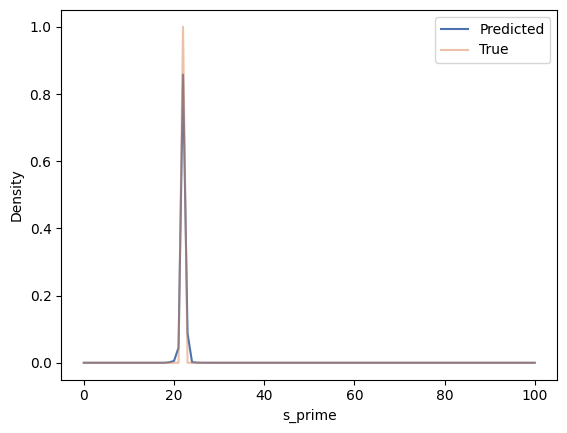

In [8]:
s = np.random.choice(states)
a = np.random.choice(actions)
t = np.random.choice(times)

row = pd.DataFrame({"s": [s], "t": [-10], "a": [a]})
pred = model.predict_proba(row[FEATURES])

mu = s - C * np.exp(-K * a)
true_dist = discretize_normal(states, mu, sigma)

print(f"Prediction shape: {pred.shape}")
print(f"Prediction sum across rows: {pred.sum(axis=1)}")

# So note that we get a probabilite that the next state is each of the states in S
# Sometimes this may not sum exatlly to 1 because of floating point errors
# But the MDP package will normalize it.

# Let's plot this distribution
fig, ax = plt.subplots()
sns.lineplot(x=states, y=pred.flatten(), ax=ax, label="Predicted")
sns.lineplot(x=states, y=true_dist, ax=ax, alpha=0.5, label="True")

plt.xlabel("s_prime")
plt.ylabel("Density")

plt.show()

### Problem Setup

In [9]:
def reward(
    s_prime: float,
    s: float,
    a: float,
    t: int,
) -> float:
    return a * (s - s_prime)

In [10]:
%%time
mdp = TimeAugmentedMDP(
    states=states,
    actions=actions,
    times=times,
    reward_function=reward,
    model=model,
    state_space_data_path="/tmp/state_space_data/",
    force_overwrite=True,
)
mdp.solve()
mdp.enforce_monotonicity(value_increasing=True, policy_increasing=False)

INFO:markov_decision_process.time_augmented_mdp:Model provided. Setting mode to 'model'
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...
/home/rob/Markov-Decision-Process-Toolkit/src/markov_decision_process/time_augmented_mdp.py:516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.loc[:, "reward"] = self.reward_function(
/home/rob/Markov-Decision-Process-Toolkit/src/markov_dec

INFO:markov_decision_process.time_augmented_mdp:MDP solved


CPU times: user 8.08 s, sys: 1.09 s, total: 9.17 s
Wall time: 4.98 s


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


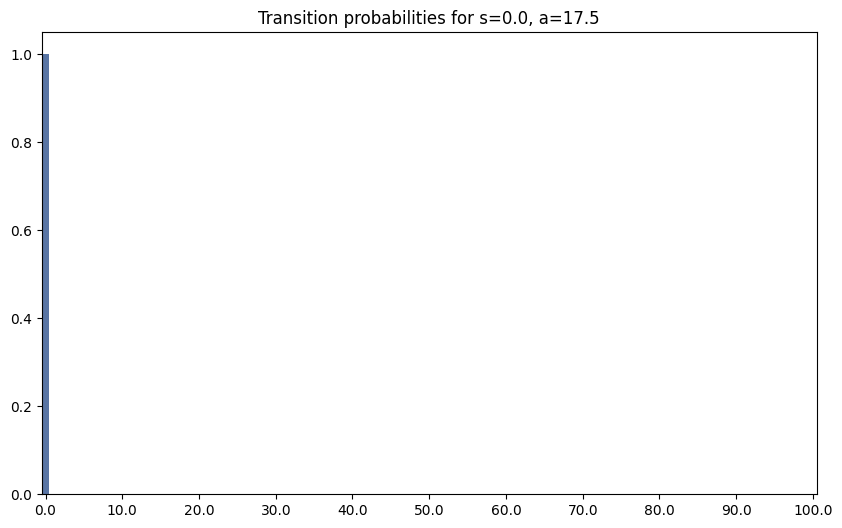

In [11]:
# Get transitions for state 50 and action 5

# Pick a random s in the state space
s = np.random.choice(mdp.states)

# Pick a random action
a = np.random.choice(mdp.actions)
a_ix = mdp.actions.index(a)

t = -30

transitions = mdp.get_transition_probabilties(s, t, a)

x = transitions["next_states"]
y = transitions["probabilities"]

plt.figure(figsize=(10, 6))

sns.barplot(x=x, y=y)

plt.title(f"Transition probabilities for s={s}, a={a}")

# Limit xticks to at most 10
plt.xticks(np.arange(0, len(x), step=max(1, len(x) // 10)))

plt.show()

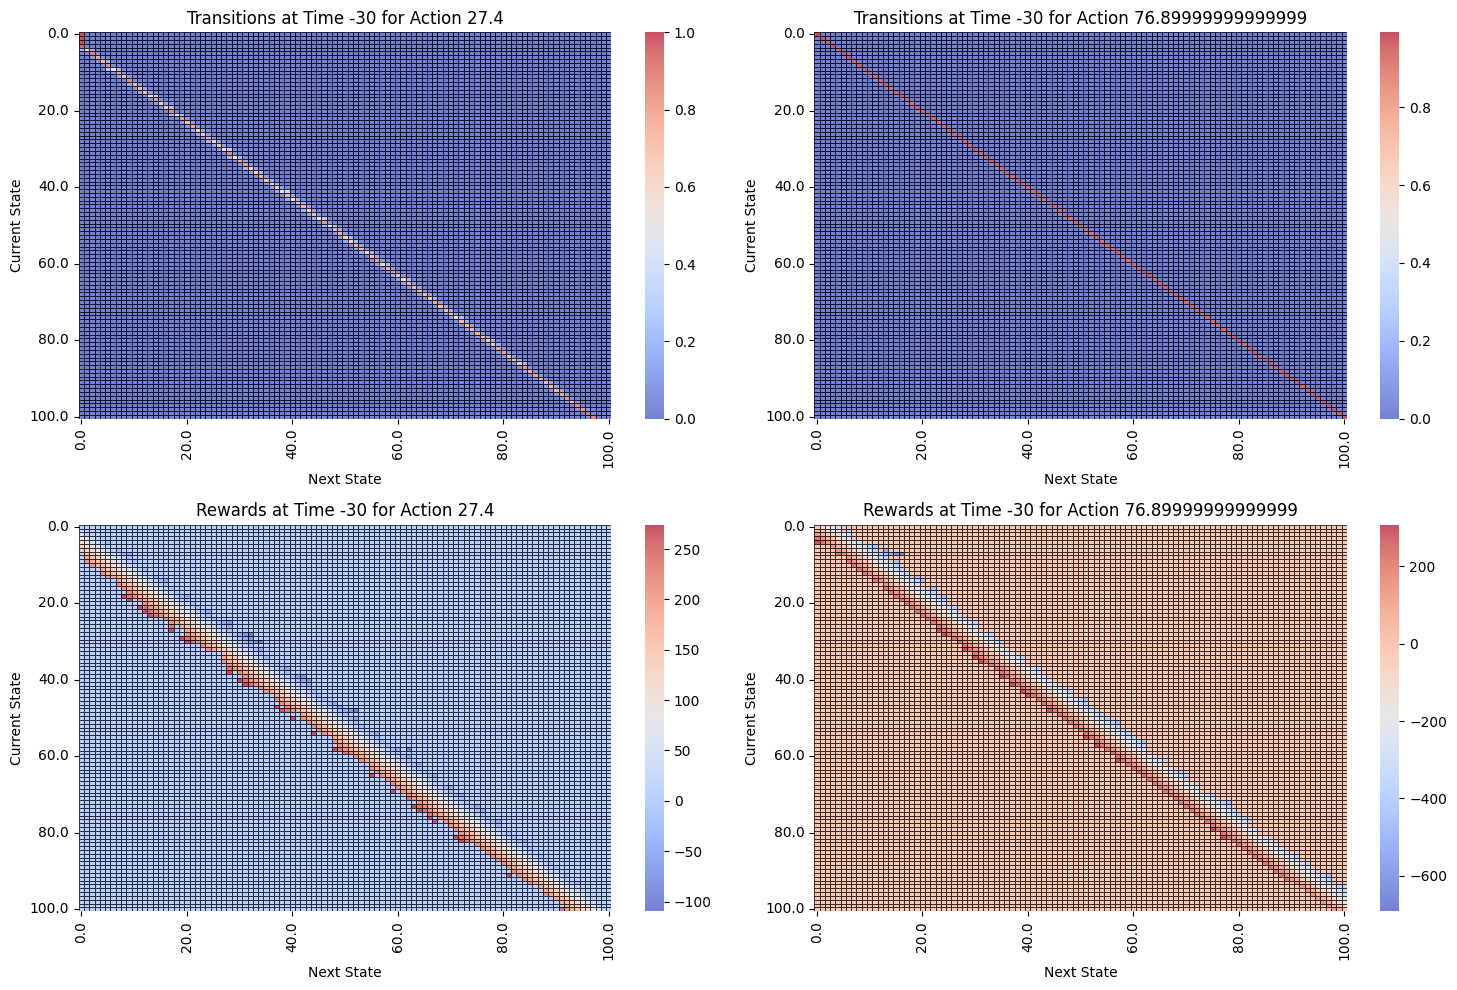

In [12]:
period = -30

quantile_25 = np.quantile(mdp.actions, 0.25)
quantile_75 = np.quantile(mdp.actions, 0.75)
action1 = mdp.actions[np.abs(mdp.actions - quantile_25).argmin()]
action2 = mdp.actions[np.abs(mdp.actions - quantile_75).argmin()]


fig, ax = plt.subplots(2, 2, figsize=(15, 10))

mdp.plot_matrix(
    matrix_type="transitions",
    t=period,
    a=action1,
    ax=ax[0, 0],
)

mdp.plot_matrix(
    matrix_type="transitions",
    t=period,
    a=action2,
    ax=ax[0, 1],
)

mdp.plot_matrix(
    matrix_type="rewards",
    t=period,
    a=action1,
    ax=ax[1, 0],
)

mdp.plot_matrix(
    matrix_type="rewards",
    t=period,
    a=action2,
    ax=ax[1, 1],
)

plt.tight_layout()
plt.show()

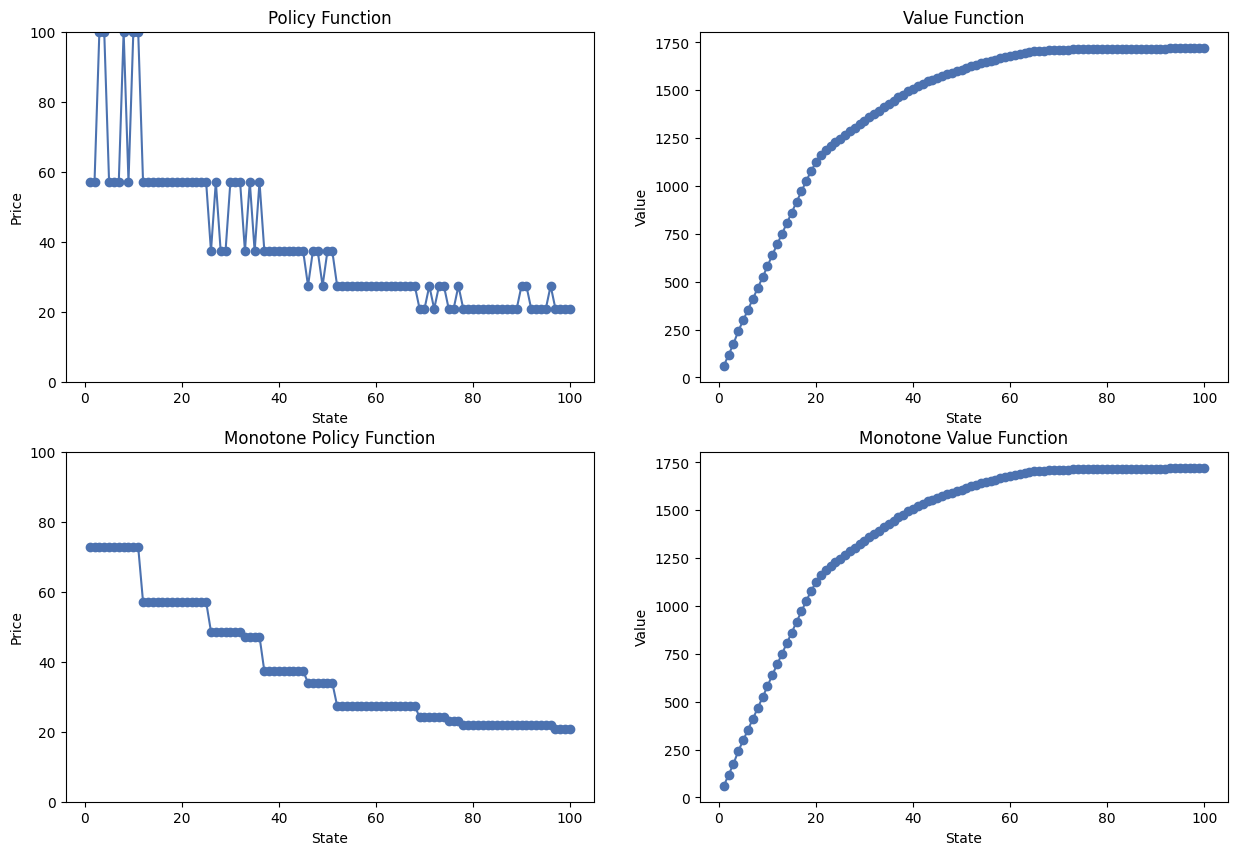

In [13]:
# Plot the optimal policy

period = -20

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

value_monotone = mdp.value_monotone[period].values()
policy_monotone = mdp.policy_monotone[period].values()


# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]
value_monotone = list(value_monotone)[1:]
policy_monotone = list(policy_monotone)[1:]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].scatter(x, policy)
ax[0, 0].plot(x, policy)
ax[0, 0].set_title("Policy Function")
ax[0, 0].set_xlabel("State")
ax[0, 0].set_ylabel("Price")
ax[0, 0].set_ylim(0, 100)

ax[0, 1].scatter(x, value)
ax[0, 1].plot(x, value)
ax[0, 1].set_title("Value Function")
ax[0, 1].set_xlabel("State")
ax[0, 1].set_ylabel("Value")

ax[1, 0].scatter(x, policy_monotone)
ax[1, 0].plot(x, policy_monotone)
ax[1, 0].set_title("Monotone Policy Function")
ax[1, 0].set_xlabel("State")
ax[1, 0].set_ylabel("Price")
ax[1, 0].set_ylim(0, 100)

ax[1, 1].scatter(x, value_monotone)
ax[1, 1].plot(x, value_monotone)
ax[1, 1].set_title("Monotone Value Function")
ax[1, 1].set_xlabel("State")
ax[1, 1].set_ylabel("Value")


plt.show()

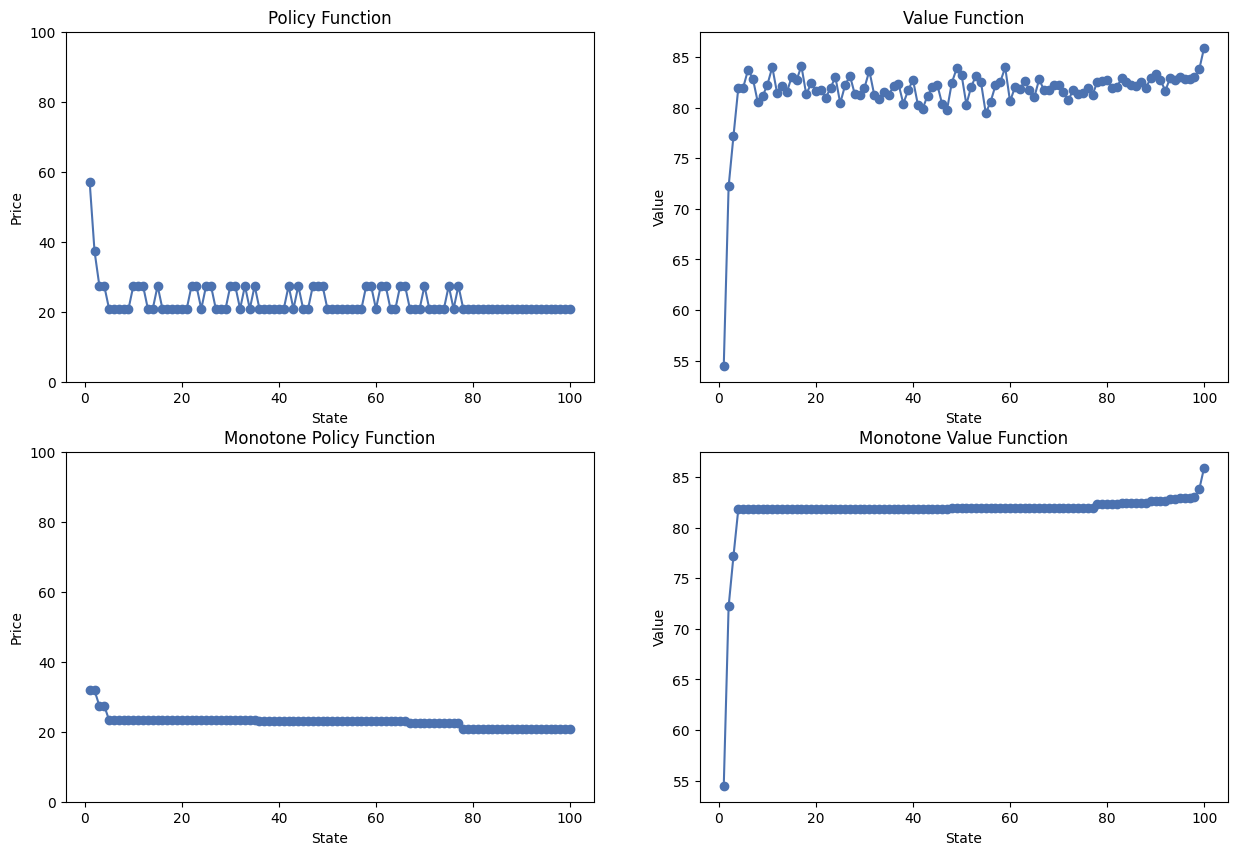

In [14]:
period = max(mdp.times) - 1


x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

value_monotone = mdp.value_monotone[period].values()
policy_monotone = mdp.policy_monotone[period].values()


# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]
value_monotone = list(value_monotone)[1:]
policy_monotone = list(policy_monotone)[1:]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].scatter(x, policy)
ax[0, 0].plot(x, policy)
ax[0, 0].set_title("Policy Function")
ax[0, 0].set_xlabel("State")
ax[0, 0].set_ylabel("Price")
ax[0, 0].set_ylim(0, 100)

ax[0, 1].scatter(x, value)
ax[0, 1].plot(x, value)
ax[0, 1].set_title("Value Function")
ax[0, 1].set_xlabel("State")
ax[0, 1].set_ylabel("Value")

ax[1, 0].scatter(x, policy_monotone)
ax[1, 0].plot(x, policy_monotone)
ax[1, 0].set_title("Monotone Policy Function")
ax[1, 0].set_xlabel("State")
ax[1, 0].set_ylabel("Price")
ax[1, 0].set_ylim(0, 100)

ax[1, 1].scatter(x, value_monotone)
ax[1, 1].plot(x, value_monotone)
ax[1, 1].set_title("Monotone Value Function")
ax[1, 1].set_xlabel("State")
ax[1, 1].set_ylabel("Value")


plt.show()